In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.stattools import adfuller, acf, pacf
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [3]:
data = pd.read_csv("docking.csv")
data

,No.,Nama Kapal,No. Kontrol,Owner,Tanggal Docking,Tanggal Undocking,Rentang Waktu (Hari),Nama Dock
0,1,TB Fatimah,R21TBFXA,PT. PELAYARAN ALBA BERKAH SAMUDERA,12/30/2021,1/14/2022,15,Irian
1,2,KM Mutiara Barat,R21MTBXA,PT ARMADA INDONESIA MANDIRI,12/31/2021,1/14/2022,14,Irian
2,3,AHT Patrona 118,R22PTNXA,PT SOWOHI KENTITI JAYA,1/15/2022,1/28/2022,13,Surabaya
3,4,KMP Niki Sejahtera,R21NSJXA,PT. BERLIAN LAUTAN SEJAHTERA,1/16/2022,2/4/2022,19,Irian
4,5,KM Tilong Kabila,R22TLKXA,PT PELNI,1/30/2022,2/18/2022,19,Surabaya
...,...,...,...,...,...,...,...,...
133,134,KRI Surabaya - 591,R24SBYDA,SATHARMAT KOARMADA II,5/2/2024,5/7/2024,5,Semarang
134,135,KM Leuser,R24LSRXA,PT PELNI,5/8/2024,5/31/2024,23,Surabaya
135,136,KRI Dewaruci,R24DRCDA,SATHARMAT KOARMADA II,5/9/2024,5/24/2024,15,Semarang
136,137,KRI OWA - 354,R24OWAKA,SATHARMAT KOARMADA II,5/28/2024,5/31/2024,3,Irian


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   No.                   138 non-null    int64 
 1   Nama Kapal            138 non-null    object
 2   No. Kontrol           129 non-null    object
 3   Owner                 136 non-null    object
 4   Tanggal Docking       138 non-null    object
 5   Tanggal Undocking     138 non-null    object
 6   Rentang Waktu (Hari)  138 non-null    int64 
 7   Nama Dock             138 non-null    object
dtypes: int64(2), object(6)
memory usage: 8.8+ KB


**Data Cleaning**
> Periksa missing values, menangani missing values, cek outlier, menangani outlier, periksa invalid values, menangani invalid values, penyesuaian tipa data

In [6]:
# Periksa Missing Values
print("Jumlah nilai yang hilang per kolom:\n", data.isnull().sum())

Jumlah nilai yang hilang per kolom:
 No.                     0
Nama Kapal              0
No. Kontrol             9
Owner                   2
Tanggal Docking         0
Tanggal Undocking       0
Rentang Waktu (Hari)    0
Nama Dock               0
dtype: int64


In [7]:
# Menangani Missing Values
data.fillna(method="ffill", inplace=True)

# Mengecek jumlah nilai yang hilang per kolom
print("Jumlah nilai yang hilang per kolom:\n", data.isnull().sum())

Jumlah nilai yang hilang per kolom:
 No.                     0
Nama Kapal              0
No. Kontrol             0
Owner                   0
Tanggal Docking         0
Tanggal Undocking       0
Rentang Waktu (Hari)    0
Nama Dock               0
dtype: int64


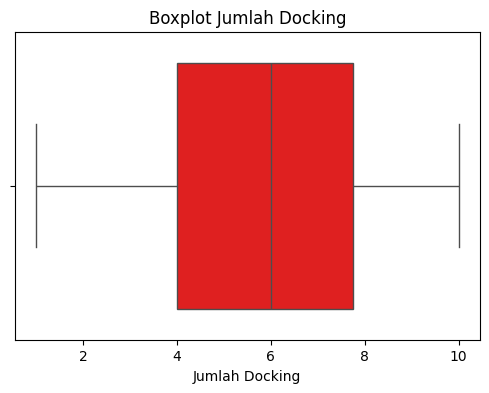

In [8]:
# Convert 'Tanggal Docking' ke datetime
data["Tanggal Docking"] = pd.to_datetime(data["Tanggal Docking"])

# Menghitung Jumlah Docking Per Bulan
data["Bulan"] = data["Tanggal Docking"].dt.to_period("M").dt.to_timestamp()

# Menghitung jumlah docking per bulan dan simpan dalam DataFrame 'data'
monthly_dockings = data.groupby("Bulan").size().reset_index(name="Jumlah Docking")
data = pd.merge(data, monthly_dockings, on="Bulan", how="left") # Gabungkan hasil perhitungan ke DataFrame 'data'

# Mendeteksi Outlier di Kolom Rentang Waktu
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.boxplot(x=data["Jumlah Docking"], color="red") # Gunakan 'data' DataFrame yang sudah diperbarui
plt.title("Boxplot Jumlah Docking")
plt.show()

Jumlah outlier menggunakan Z-score: 0


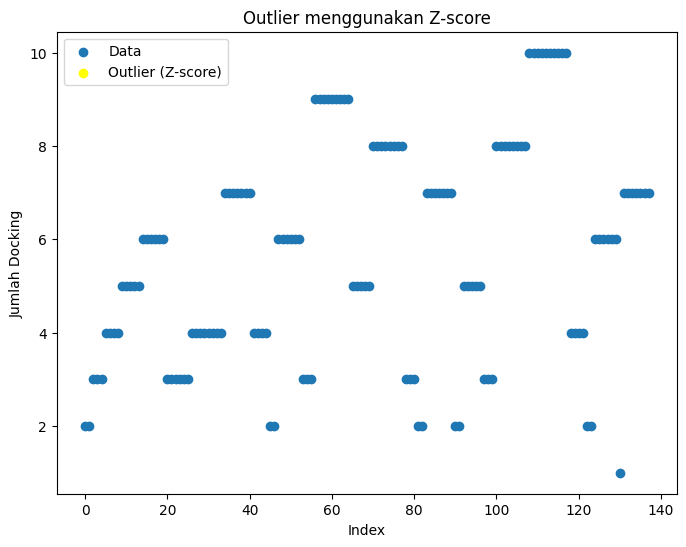

In [9]:
# Mendeteksi Outlier Menggunakan Z-Score
z_scores = stats.zscore(data["Jumlah Docking"])
threshold = 3
outliers = np.where(np.abs(z_scores) > threshold)[0]
print(f"Jumlah outlier menggunakan Z-score: {len(outliers)}")

# Visualisasi Hasil Deteksi Outlier
plt.figure(figsize=(8, 6))
plt.scatter(data.index, data["Jumlah Docking"], label="Data")
plt.scatter(data.index[outliers], data["Jumlah Docking"].iloc[outliers], color="yellow", label="Outlier (Z-score)")
plt.title("Outlier menggunakan Z-score")
plt.xlabel("Index")
plt.ylabel("Jumlah Docking")
plt.legend()
plt.show()

In [10]:
# Mengubah Tipe Data Sebelum Memeriksa Nilai Tidak Valid
data["Tanggal Docking"] = pd.to_datetime(data["Tanggal Docking"])

# Periksa Jumlah Nilai Tidak Valid pada Kolom Rentang Waktu
invalid_values = data["Jumlah Docking"].isna().sum()
print(f"Jumlah nilai yang tidak valid dalam kolom Jumlah Docking: {invalid_values}")

Jumlah nilai yang tidak valid dalam kolom Jumlah Docking: 0


**Data Exploration and Preprocessing**
> Menghitung jumlah docking per bulan, plot persebaran rentang waktu kapal melakukan docking, cek stasioneritas data dan melakukan differencing data apabila data tidak stasioner.

In [15]:
# Menghitung Jumlah Docking Per Bulan
data["Bulan"] = data["Tanggal Docking"].dt.to_period("M").dt.to_timestamp()

monthly_dockings = data.groupby("Bulan").size().reset_index(name="Jumlah Docking")
data = data.merge(monthly_dockings, on="Bulan", how="left")

# Menampilkan hasil
print(monthly_dockings)

        Bulan  Jumlah Docking
0  2021-12-01               2
1  2022-01-01               3
2  2022-02-01               4
3  2022-03-01               5
4  2022-04-01               6
5  2022-05-01               3
6  2022-06-01               3
7  2022-07-01               4
8  2022-08-01               4
9  2022-09-01               7
10 2022-10-01               4
11 2022-11-01               2
12 2022-12-01               6
13 2023-01-01               3
14 2023-02-01               9
15 2023-03-01               5
16 2023-04-01               8
17 2023-05-01               3
18 2023-06-01               2
19 2023-07-01               7
20 2023-08-01               2
21 2023-09-01               5
22 2023-10-01               3
23 2023-11-01               8
24 2023-12-01              10
25 2024-01-01               4
26 2024-02-01               2
27 2024-03-01               6
28 2024-04-01               1
29 2024-05-01               7


Tanggal Docking
2023-12-29    4
2023-04-19    4
2024-05-02    3
2023-02-21    3
2022-09-08    3
             ..
2022-12-08    1
2022-12-01    1
2022-11-15    1
2022-11-07    1
2023-03-25    1
Name: count, Length: 98, dtype: int64


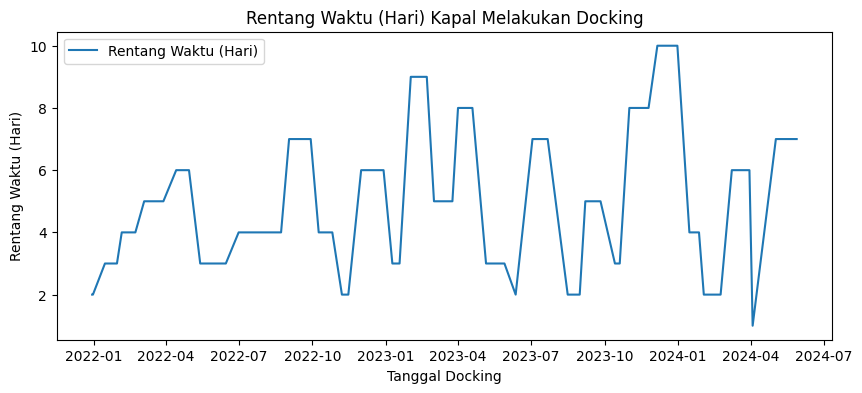

In [16]:
waktudocking = data.value_counts(data["Tanggal Docking"])
print(waktudocking)

# Plot Persebaran Kapal Yang Melakukan Docking
plt.figure(figsize=(10, 4))
plt.plot(data["Tanggal Docking"], data["Jumlah Docking"], label="Rentang Waktu (Hari)")
plt.title("Rentang Waktu (Hari) Kapal Melakukan Docking")
plt.xlabel("Tanggal Docking")
plt.ylabel("Rentang Waktu (Hari)")
plt.legend()
plt.show()

In [17]:
result = adfuller(data["Jumlah Docking"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Interpretasi hasil uji ADF
if result[1] < 0.05:
  print('Hasil uji menunjukkan bahwa data stasioner.\n')
else:
  print('Hasil uji menunjukkan bahwa data tidak stasioner.\n')

ADF Statistic: -4.414631
p-value: 0.000280
Hasil uji menunjukkan bahwa data stasioner.



**Data Modelling**
> Menerapkan model ARIMA, melakukan forecasting

In [19]:
# Auto ARIMA untuk menemukan parameter terbaik
# Memuat data
data_series = data["Jumlah Docking"]
model = auto_arima(data_series, seasonal=True, m=12, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True)
model_fit = model.fit(data_series)
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=523.932, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=519.744, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=520.728, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=522.002, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=524.955, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=520.779, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=520.756, Time=0.50 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=520.868, Time=0.23 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=522.693, Time=0.86 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=518.522, Time=0.15 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=519.958, Time=0.38 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=519.828, Time=0.40 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=519.496, Time=0.18 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   

In [20]:
# Oder Arima (1, 1, 1)
# Membagi data menjadi data pelatihan dan pengujian
train_size = int(len(data["Jumlah Docking"]) * 0.8)
train = data["Jumlah Docking"][:train_size].values

# Import the correct ARIMA class
from statsmodels.tsa.arima.model import ARIMA

# Build ARIMA Model
model_arima = ARIMA(train, order=(1, 1, 1))
fitted = model_arima.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -193.501
Date:                Tue, 25 Jun 2024   AIC                            393.002
Time:                        01:57:18   BIC                            401.076
Sample:                             0   HQIC                           396.276
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7713      0.103      7.480      0.000       0.569       0.973
ma.L1         -0.9665      0.043    -22.232      0.000      -1.052      -0.881
sigma2         2.0227      0.240      8.427      0.0

In [21]:
# Oder Arima (1, 0, 0)
# Membagi data menjadi data pelatihan dan pengujian
train_size = int(len(data["Jumlah Docking"]) * 0.8)
train = data["Jumlah Docking"][:train_size].values

# Import the correct ARIMA class
from statsmodels.tsa.arima.model import ARIMA

# Build ARIMA Model
model_arima = ARIMA(train, order=(1, 0, 0)) # Use the updated ARIMA class
fitted = model_arima.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -194.339
Date:                Tue, 25 Jun 2024   AIC                            394.679
Time:                        01:57:19   BIC                            402.780
Sample:                             0   HQIC                           397.965
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5568      0.616      9.015      0.000       4.349       6.765
ar.L1          0.7856      0.094      8.351      0.000       0.601       0.970
sigma2         1.9874      0.253      7.864      0.0

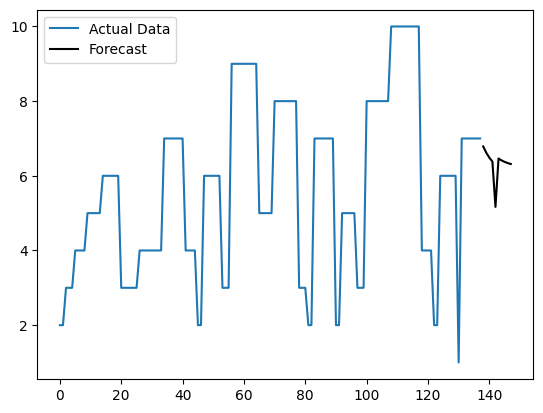

In [22]:
# Prediksi dengan model ARIMA
pred = model_fit.predict(dynamic=False)

# Plot hasil prediksi
plt.plot(data["Jumlah Docking"], label="Actual Data")
plt.plot(pred, label="Forecast", color="black")
plt.legend()
plt.show()

In [30]:
# Membagi data menjadi 20% untuk data latih dan 80% untuk data uji
train_size = int(len(data["Jumlah Docking"]) * 0.2)
train = data["Jumlah Docking"][:train_size]
test = data["Jumlah Docking"][train_size:]

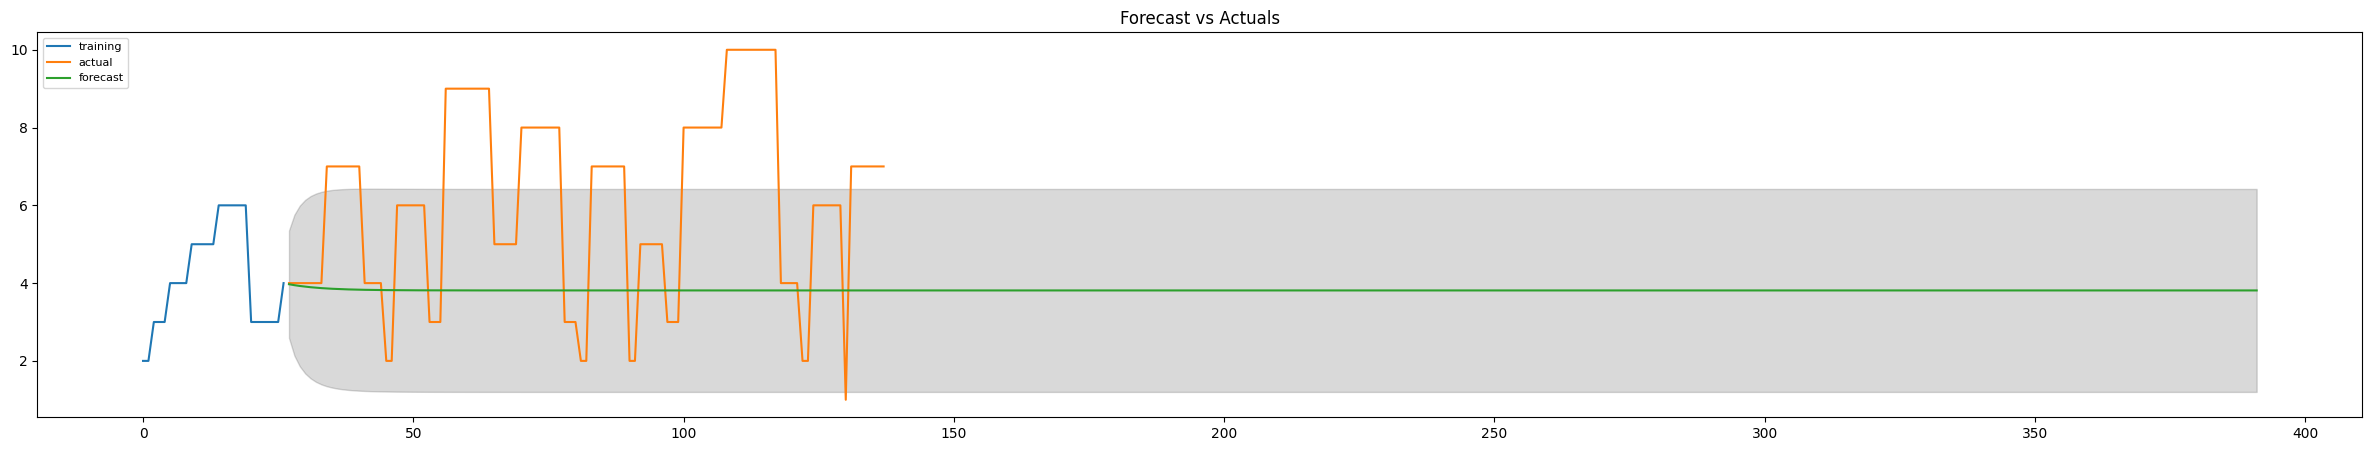

In [31]:
# Build Model
model = ARIMA(train, order=(1, 0, 0))
fitted = model.fit()

# Forecast
fc = fitted.forecast(steps=365)

# Membuat interval kepercayaan 95%
conf_int = fitted.get_forecast(steps=365).conf_int()

# Mengambil prediksi dan batas atas dan bawah dari interval kepercayaan
pred = fc
lower = conf_int.iloc[:, 0]
upper = conf_int.iloc[:, 1]

# Plot
plt.figure(figsize=(30,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc, label='forecast')
plt.fill_between(lower.index, lower, upper, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

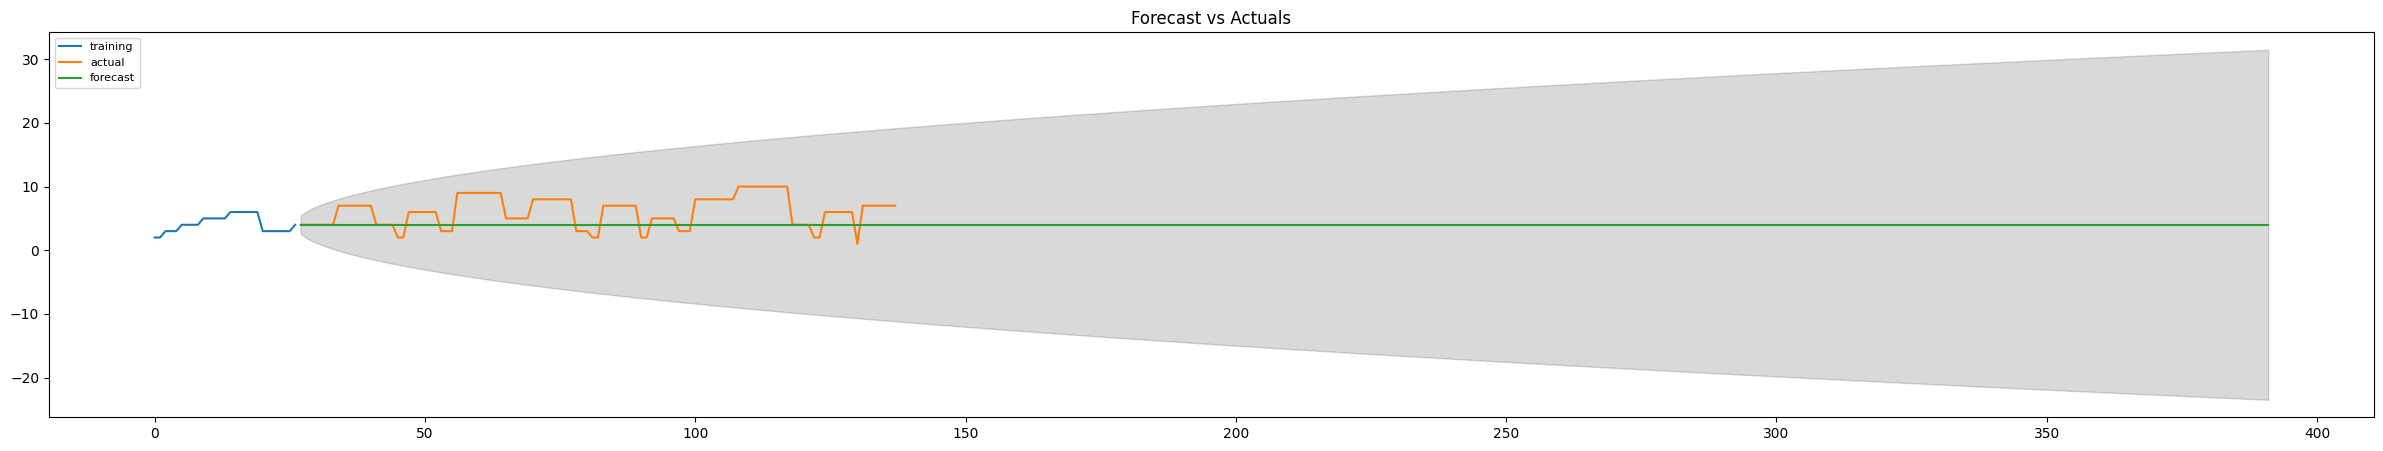

In [32]:
# Build Model
model = ARIMA(train, order=(1, 1, 1))
fitted = model.fit()

# Forecast
fc = fitted.forecast(steps=365)

# Membuat interval kepercayaan 95%
conf_int = fitted.get_forecast(steps=365).conf_int()

# Mengambil prediksi dan batas atas dan bawah dari interval kepercayaan
pred = fc
lower = conf_int.iloc[:, 0]
upper = conf_int.iloc[:, 1]

# Plot
plt.figure(figsize=(30,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc, label='forecast')
plt.fill_between(lower.index, lower, upper, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**Data Evaluation**
> Melakukan evaluasi model dengan menghitung nilai MSE, MRSE, MAE

In [33]:
# Buat prediksi
model_fit = model.fit()
pred_start = 80
predictions = model_fit.predict(start=pred_start, end=len(data)-1)

# Data asli untuk evaluasi
actual_values = data["Jumlah Docking"][pred_start:]

# Isi nilai NaN dengan nilai sebelumnya (forward fill) atau metode pengisian lainnya
actual_values.fillna(method='ffill', inplace=True)
predictions.fillna(method='ffill', inplace=True)  # Asumsi bahwa predictions juga mungkin mengandung NaN

# Hitung MSE
mse = mean_squared_error(actual_values, predictions)

# Hitung RMSE
rmse = np.sqrt(mse)

# Hitung MAE
mae = mean_absolute_error(actual_values, predictions)

# Print hasil evaluasi
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 11.724137930952615
Root Mean Squared Error (RMSE): 3.4240528516587787
Mean Absolute Error (MAE): 2.9310344827499373
